In [2]:
import os
import subprocess
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from utils import extract_dataset
from datetime import datetime


C:\Users\madY\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\madY\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

if not os.path.exists('Preprocessed_GDP_Dataset.csv'):
    subprocess.run(["python3", "preprocess_gdp_dataset.py"])

dataset_file_path = extract_dataset('GlobalTerrorismDataset.zip')
df = pd.read_csv(dataset_file_path, encoding='ISO-8859-1', low_memory=False)

globalterrorismdb_0718dist.csv already exists!


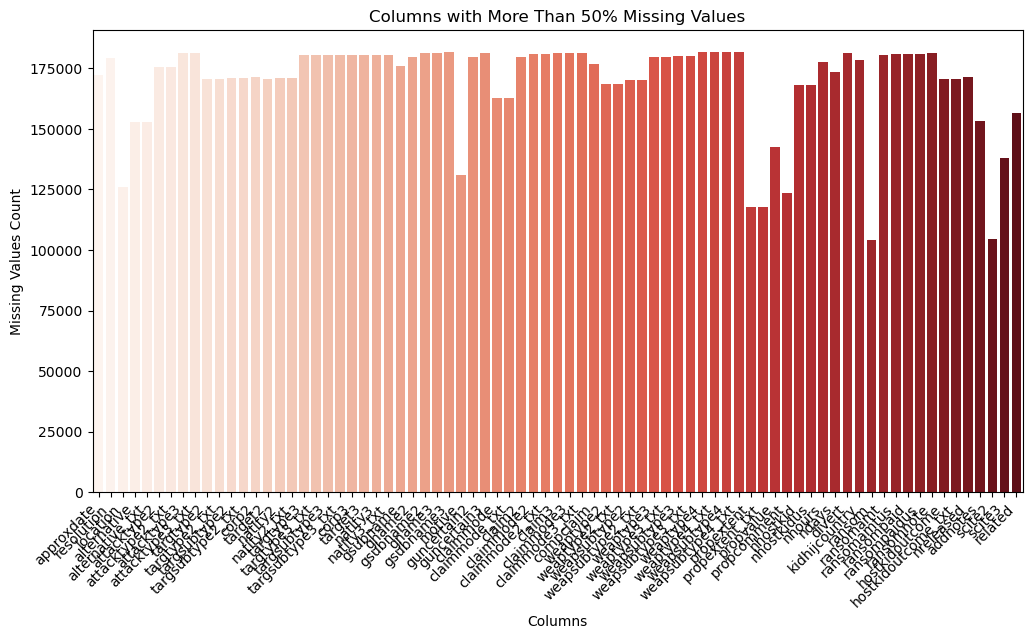

In [4]:
# Calculate missing values and completeness percentage
missing_values = df.isnull().sum()
completeness_percentage = (1 - (missing_values / len(df))) * 100

completeness_analysis = pd.DataFrame({
    'Missing Values Count': missing_values,
    'Completeness Percentage': completeness_percentage
})

columns_50p_missing = completeness_analysis[completeness_analysis['Completeness Percentage'] < 50]

# Bar Plot for Columns with More Than 50% Missing Values
if not columns_50p_missing.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=columns_50p_missing.index,
        y=columns_50p_missing['Missing Values Count'],
        palette='Reds'
    )
    plt.xticks(rotation=45, ha='right')
    plt.title('Columns with More Than 50% Missing Values')
    plt.xlabel('Columns')
    plt.ylabel('Missing Values Count')
    plt.show()
else:
    print('No columns have more than 50% missing values.')

In [5]:
selected_columns = [
    'iyear', 'imonth', 'iday', 'extended', 'resolution', 'country_txt', 
    'region_txt', 'city', 'success', 'suicide', 'attacktype1_txt', 
    'targtype1_txt', 'natlty1_txt', 'gname', 'nperps', 'weaptype1_txt', 
    'nkill', 'nwound', 'nkillus', 'nwoundus', 'dbsource'
]

column_renaming = {
    'iyear': 'Year', 'imonth': 'Month', 'iday': 'Day', 'extended': 'Extended', 
    'resolution': 'Resolution', 'country_txt': 'Country', 'region_txt': 'Region', 
    'city': 'City', 'success': 'Success', 'suicide': 'Suicide', 
    'attacktype1_txt': 'Attack Type', 'targtype1_txt': 'Target Type', 
    'natlty1_txt': 'Target Nationality', 'gname': 'Attacking Group Name', 
    'nperps': 'Number of Terrorists', 'weaptype1_txt': 'Weapon Type', 
    'nkill': 'Number of Killed People', 'nwound': 'Number of Wounded People', 
    'nkillus': 'Number of Killed US People', 'nwoundus': 'Number of Wounded US People', 
    'dbsource': 'Database Source'
}

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


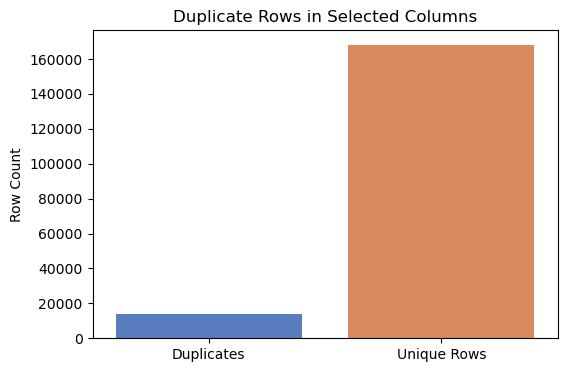

No invalid kill counts found in the selected columns.
All required date columns are present in the selected columns.


In [6]:
df_selected = df[selected_columns]

unique_counts = df_selected.nunique()
duplicate_count = df_selected.duplicated().sum()
if duplicate_count > 0:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=['Duplicates', 'Unique Rows'], y=[duplicate_count, len(df_selected) - duplicate_count], palette='muted')
    plt.title('Duplicate Rows in Selected Columns')
    plt.ylabel('Row Count')
    plt.show()
else:
    print('No duplicate rows found in the selected columns.')

invalid_kill_counts = df_selected[df_selected['nkill'] < 0]
if invalid_kill_counts.empty:
    print('No invalid kill counts found in the selected columns.')

# Check for missing required date columns
required_columns = ['iyear', 'imonth', 'iday']
missing_columns = [col for col in required_columns if col not in df_selected.columns]
if missing_columns:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=missing_columns, y=[1] * len(missing_columns), palette='coolwarm')
    plt.title('Missing Required Date Columns')
    plt.xlabel('Required Columns')
    plt.ylabel('Presence (0 = Missing, 1 = Present)')
    plt.yticks([])
    plt.show()
else:
    print('All required date columns are present in the selected columns.')

In [7]:
filtered_df = df_selected.rename(columns=column_renaming)

def is_valid_date(year, month, day):
    """Check if the given year, month, day form a valid date."""
    try:
        datetime(year, month, day)
        return True
    except ValueError:
        return False

def calculate_duration(row):
    """Calculate the duration of an attack if extended and resolution date exists."""
    if not is_valid_date(row['Year'], row['Month'], row['Day']):
        return 0
    
    if row['Extended'] == 1 and pd.notnull(row['Resolution']):
        attack_date = datetime(row['Year'], row['Month'], row['Day'])
        try:
            resolution_date = datetime.strptime(row['Resolution'], "%m/%d/%Y")
            return (resolution_date - attack_date).days
        except ValueError:
            return 1
    return 1

# Apply the duration calculation
filtered_df['Duration'] = filtered_df.apply(calculate_duration, axis=1)
filtered_df = filtered_df.drop(columns=['Extended', 'Resolution'])

def calculate_casualties(row):
    """Calculate the total number of casualties by adding killed and wounded people."""
    if pd.isnull(row['Number of Killed People']) or pd.isnull(row['Number of Wounded People']):
        return -99
    return row['Number of Killed People'] + row['Number of Wounded People']

# Apply the casualties calculation
filtered_df['Number of Casualties'] = filtered_df.apply(calculate_casualties, axis=1)

# Replace null values with -99 or 'Unknown'
filtered_df['Number of Terrorists'] = filtered_df['Number of Terrorists'].fillna(-99)
filtered_df['Number of Killed People'] = filtered_df['Number of Killed People'].fillna(-99)
filtered_df['Number of Wounded People'] = filtered_df['Number of Wounded People'].fillna(-99)
filtered_df['Number of Killed US People'] = filtered_df['Number of Killed US People'].fillna(-99)
filtered_df['Number of Wounded US People'] = filtered_df['Number of Wounded US People'].fillna(-99)
filtered_df['Target Nationality'] = filtered_df['Target Nationality'].fillna('Unknown')


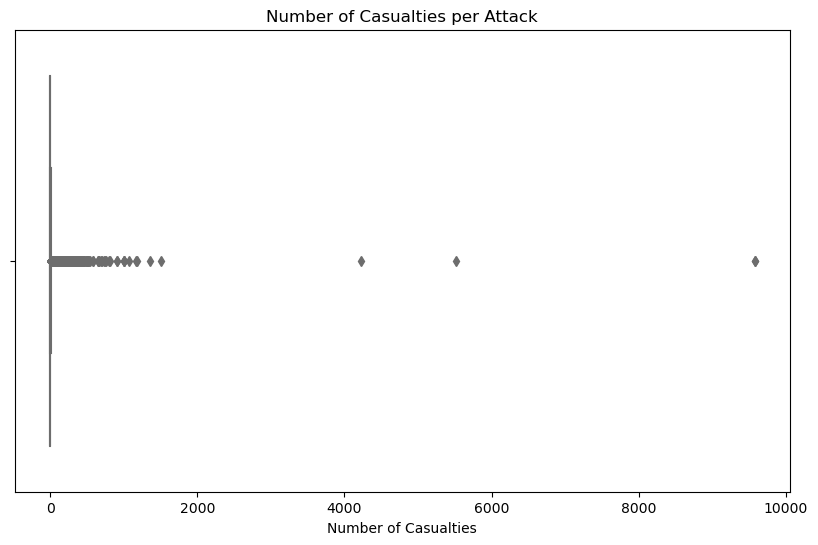

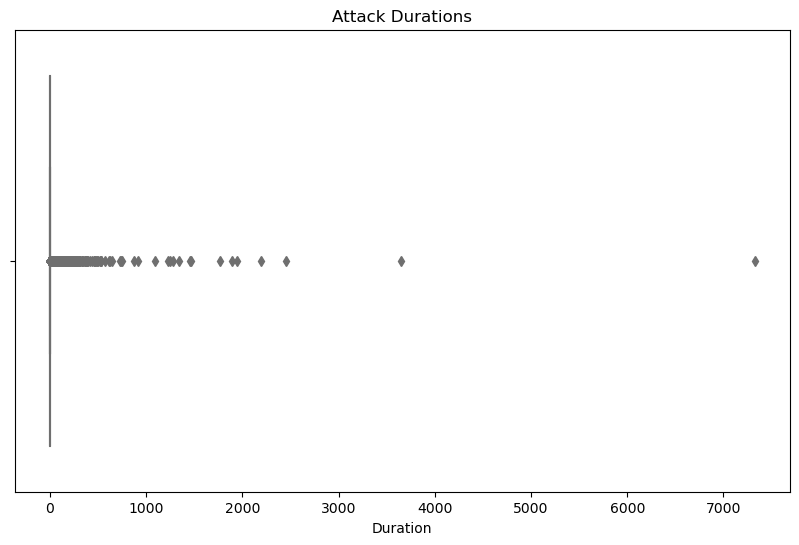

In [8]:
# Boxplot of Number of Casualties
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_df[filtered_df['Number of Casualties'] != -99]['Number of Casualties'], 
            color='salmon')
plt.title('Number of Casualties per Attack')
plt.xlabel('Number of Casualties')
plt.show()

# Boxplot of Attack Durations (excluding 0 or negative durations)
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_df[filtered_df['Duration'] > 0]['Duration'], 
            color='skyblue')
plt.title('Attack Durations')
plt.xlabel('Duration')
plt.show()

In [9]:
gdp_df = pd.read_csv('Preprocessed_GDP_Dataset.csv')
merged_df = pd.merge(filtered_df, gdp_df, how='left', on=['Year', 'Country'])

merged_df['Decade'] = (merged_df['Year'] // 10) * 10  
attack_counts = merged_df.groupby(['Decade', 'Country']).size().reset_index(name='Attack Count')
gdp_by_decade = merged_df.groupby(['Decade', 'Country'])['GDP'].mean().reset_index()
final_df = pd.merge(attack_counts, gdp_by_decade, on=['Decade', 'Country'], how='left')


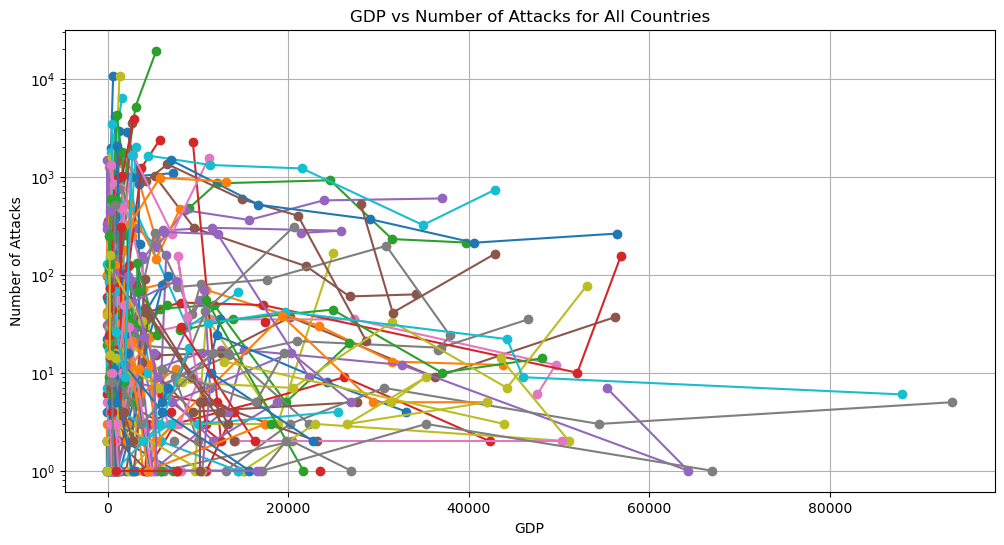

In [10]:
plot_all_countries = True     # Change to False to plot a specific country
specific_country = 'United States'  # Desired Country

plt.figure(figsize=(12, 6))

if plot_all_countries:
    for country in final_df['Country'].unique():
        country_data = final_df[final_df['Country'] == country]
        plt.plot(country_data['GDP'], country_data['Attack Count'], marker='o', label=country)
else:
    country_data = final_df[final_df['Country'] == specific_country]
    plt.plot(country_data['GDP'], country_data['Attack Count'], marker='o', label=specific_country)

    # Annotate the decades on the plot
    for i, row in country_data.iterrows():
        plt.annotate(row['Decade'], (row['GDP'], row['Attack Count']), textcoords="offset points", 
                     xytext=(0,5), ha='center', fontsize=8)

if plot_all_countries:
    plt.title('GDP vs Number of Attacks for All Countries')
else:
    plt.title(f'GDP vs Number of Attacks for {specific_country}')

plt.xlabel('GDP')
plt.ylabel('Number of Attacks')
plt.yscale('log')
plt.grid()
#plt.legend(title='Country') if plot_all_countries else plt.legend(title=specific_country)
plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


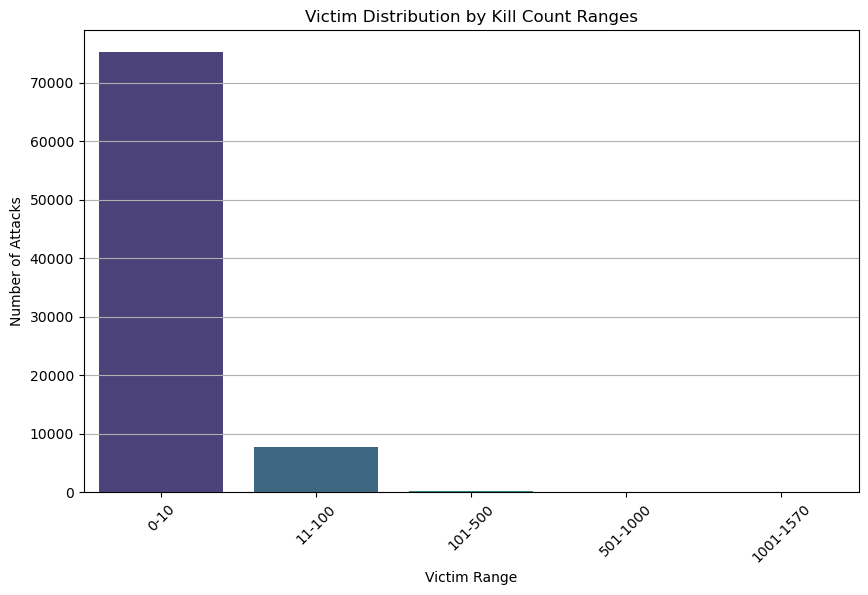

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


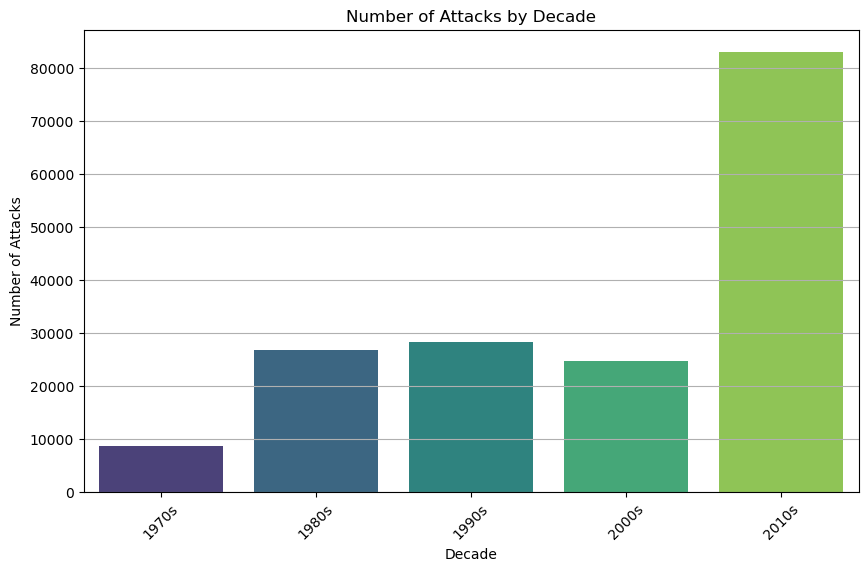

In [11]:
# --- Discretization ---
bins = [0, 10, 100, 500, 1000, 1570]
labels = ['0-10', '11-100', '101-500', '501-1000', '1001-1570']
df['victim_range'] = pd.cut(df['nkill'], bins=bins, labels=labels, right=True)

df_cleaned = df.dropna(subset=['nkill', 'victim_range'])

victim_distribution = df_cleaned['victim_range'].value_counts()

# Decade Distribution
bins_decades = [1970, 1980, 1990, 2000, 2010, 2020]  
labels_decades = ['1970s', '1980s', '1990s', '2000s', '2010s']  
df['decade'] = pd.cut(df['iyear'], bins=bins_decades, labels=labels_decades, right=False)

df_cleaned = df.dropna(subset=['nkill', 'decade'])

decade_distribution = df_cleaned['decade'].value_counts()

# Plot for Victim Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=victim_distribution.index, y=victim_distribution.values, palette='viridis')
plt.title('Victim Distribution by Kill Count Ranges')
plt.xlabel('Victim Range')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Plot for Decade Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=decade_distribution.index, y=decade_distribution.values, palette='viridis')
plt.title('Number of Attacks by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [12]:
df['attacktype1'] = df['attacktype1'].replace('', np.nan).fillna('Unknown')
df['weaptype1'] = df['weaptype1'].replace('', np.nan).fillna('Unknown')

# One-hot encode the 'attacktype1' and 'weaptype1' columns
attack_weap_dummies = pd.get_dummies(df[['attacktype1', 'weaptype1']], drop_first=True)

other_features = df[['nperps', 'nkill', 'suicide', 'success']]
features = pd.concat([other_features, attack_weap_dummies], axis=1)
features = features.applymap(lambda x: np.nan if x < 0 else x)
features.fillna(features.median(), inplace=True)

scaler = StandardScaler()
features[['nperps', 'nkill']] = scaler.fit_transform(features[['nperps', 'nkill']])
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)
reduced_df = pd.DataFrame(data=reduced_features, columns=['PC1', 'PC2'])

C:\Users\madY\AppData\Local\Temp\ipykernel_14196\3902332300.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  features = features.applymap(lambda x: np.nan if x < 0 else x)


In [13]:
reduced_df.head()

,PC1,PC2
0,3.619660,-5.901129
1,6.804814,-2.049591
2,3.619660,-5.901129
3,-0.502199,0.096468
4,3.587298,1.902967


# --------------------------------------------------------------

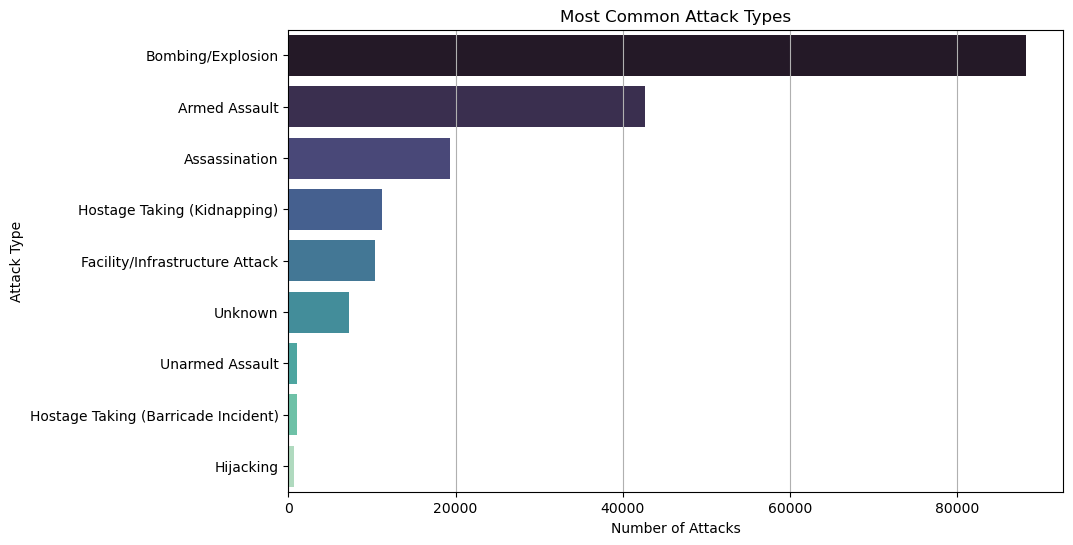

In [14]:
# Most Common Attack Types
attack_type_counts = filtered_df['Attack Type'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=attack_type_counts.values, y=attack_type_counts.index, palette='mako')
plt.title('Most Common Attack Types')
plt.xlabel('Number of Attacks')
plt.ylabel('Attack Type')
plt.grid(axis='x')
plt.show()


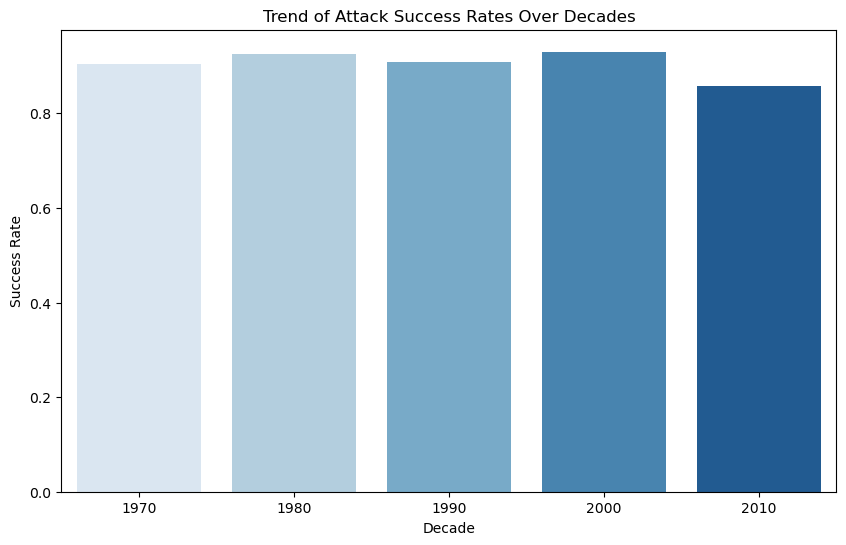

In [15]:
decadal_success_rate = merged_df.groupby('Decade')['Success'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Decade', y='Success', data=decadal_success_rate, palette='Blues')
plt.title('Trend of Attack Success Rates Over Decades')
plt.xlabel('Decade')
plt.ylabel('Success Rate')
plt.show()


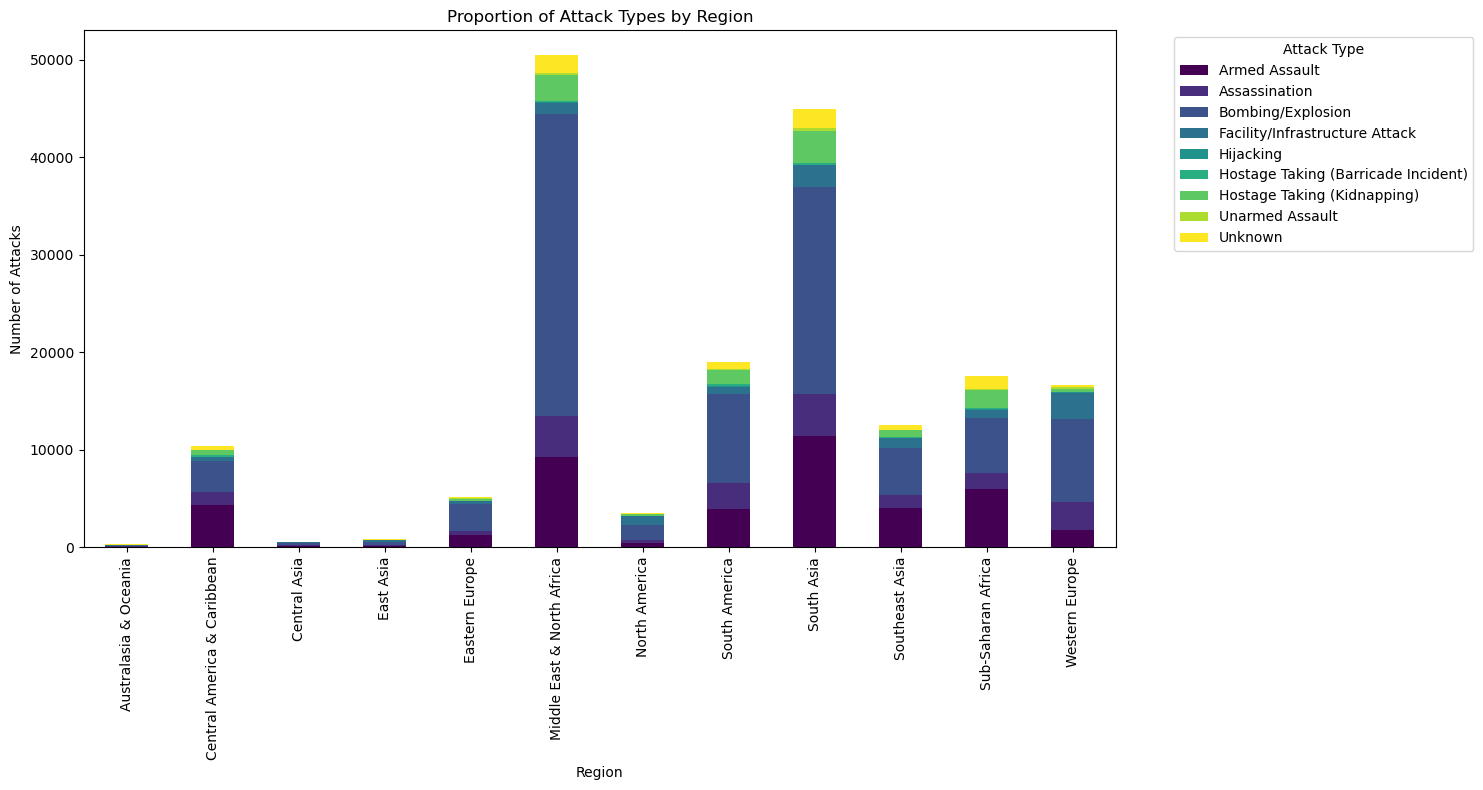

In [16]:
attack_region = filtered_df.groupby(['Region', 'Attack Type']).size().unstack(fill_value=0)

attack_region.plot(kind='bar', stacked=True, figsize=(15, 8), colormap='viridis')
plt.title('Proportion of Attack Types by Region')
plt.xlabel('Region')
plt.ylabel('Number of Attacks')
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


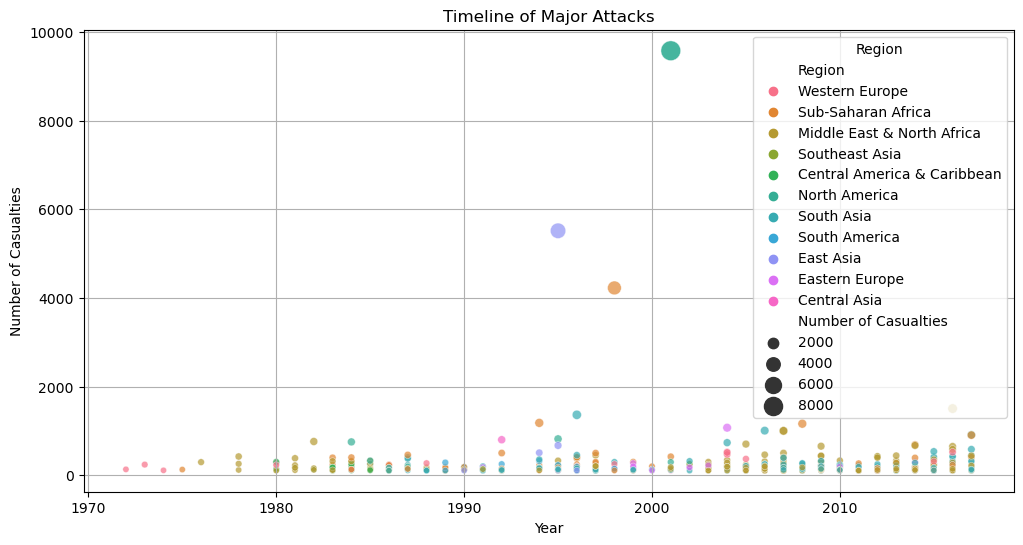

In [17]:
major_attacks = filtered_df[filtered_df['Number of Casualties'] > 100]  # Adjust threshold

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Year', y='Number of Casualties', data=major_attacks, hue='Region', size='Number of Casualties', sizes=(20, 200), alpha=0.7)
plt.title('Timeline of Major Attacks')
plt.xlabel('Year')
plt.ylabel('Number of Casualties')
plt.legend(title='Region', loc='upper right')
plt.grid()
plt.show()


In [18]:
# Identify all numeric columns in the DataFrame
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns

exclude_columns = ['Year', 'Decade', 'Number of Wounded US People', 'Number of Killed US People']
filtered_numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

# Replace negative values with NaN across filtered numeric columns
for col in filtered_numeric_columns:
    merged_df[col] = merged_df[col].apply(lambda x: np.nan if x < 0 else x)

# Now compute and print descriptive statistics excluding NaN (i.e., negative values)
print("Descriptive Statistics (Mean, Median, Std, Min, Max, Count):\n")
print("Mean:\n", merged_df[filtered_numeric_columns].mean(), "\n")
print("Median:\n", merged_df[filtered_numeric_columns].median(), "\n")
print("Standard Deviation:\n", merged_df[filtered_numeric_columns].std(), "\n")
print("Min:\n", merged_df[filtered_numeric_columns].min(), "\n")
print("Max:\n", merged_df[filtered_numeric_columns].max(), "\n")
print("Count:\n", merged_df[filtered_numeric_columns].count(), "\n")

print("Summary (describe):\n", merged_df[filtered_numeric_columns].describe())

Descriptive Statistics (Mean, Median, Std, Min, Max, Count):

Mean:
 Month                          6.467578
Day                           15.505975
Success                        0.889559
Suicide                        0.036467
Number of Terrorists          32.255752
Number of Killed People        2.415851
Number of Wounded People       3.172350
Duration                       1.450808
Number of Casualties           5.311164
GDP                         4538.572150
dtype: float64 

Median:
 Month                          6.000000
Day                           15.000000
Success                        1.000000
Suicide                        0.000000
Number of Terrorists           2.000000
Number of Killed People        0.000000
Number of Wounded People       0.000000
Duration                       1.000000
Number of Casualties           1.000000
GDP                         1767.347081
dtype: float64 

Standard Deviation:
 Month                          3.388224
Day                        

In [19]:
# Select categorical columns (typically 'object' or 'category' types), excluding 'City'
categorical_columns = [
    col for col in merged_df.select_dtypes(include=['object', 'category']).columns
    if col != 'City'
]

print("Categorical Columns Distribution:\n")
for col in categorical_columns:
    value_counts = merged_df[col].value_counts(dropna=False)
    print(f"Column: {col}")
    print(value_counts)
    print("\nTop 10 Categories in", col, ":\n", value_counts.head(10), "\n")


Categorical Columns Distribution:

Column: Country
Country
Iraq                                24636
Pakistan                            14368
Afghanistan                         12731
India                               11960
Colombia                             8306
Philippines                          6908
Peru                                 6096
El Salvador                          5320
United Kingdom                       5235
Turkey                               4292
Somalia                              4142
Nigeria                              3907
Thailand                             3849
Yemen                                3347
Spain                                3249
Sri Lanka                            3022
United States                        2836
Algeria                              2743
France                               2693
Egypt                                2479
Lebanon                              2478
Chile                                2365
Libya            

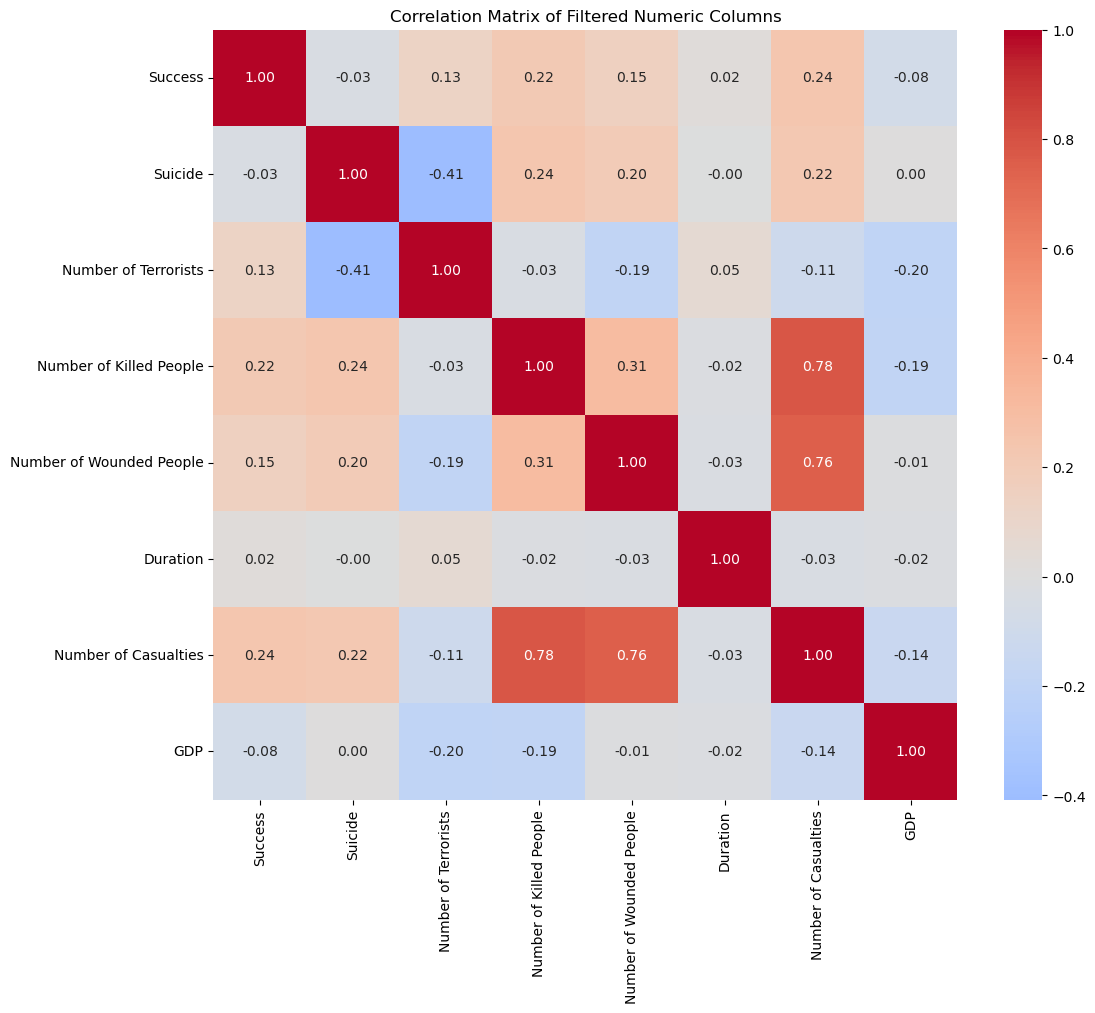

In [20]:
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns
exclude_columns = ['Year', 'Month', 'Day', 'Decade', 'Number of Wounded US People', 'Number of Killed US People']

# Filter out excluded columns
filtered_numeric_columns = [col for col in numeric_columns if col not in exclude_columns]

# Replace negative values with NaN across filtered numeric columns
for col in filtered_numeric_columns:
    merged_df[col] = merged_df[col].apply(lambda x: np.nan if x < 0 else x)

# Compute the correlation matrix for the filtered columns
corr_matrix = merged_df[filtered_numeric_columns].corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Filtered Numeric Columns')
plt.show()

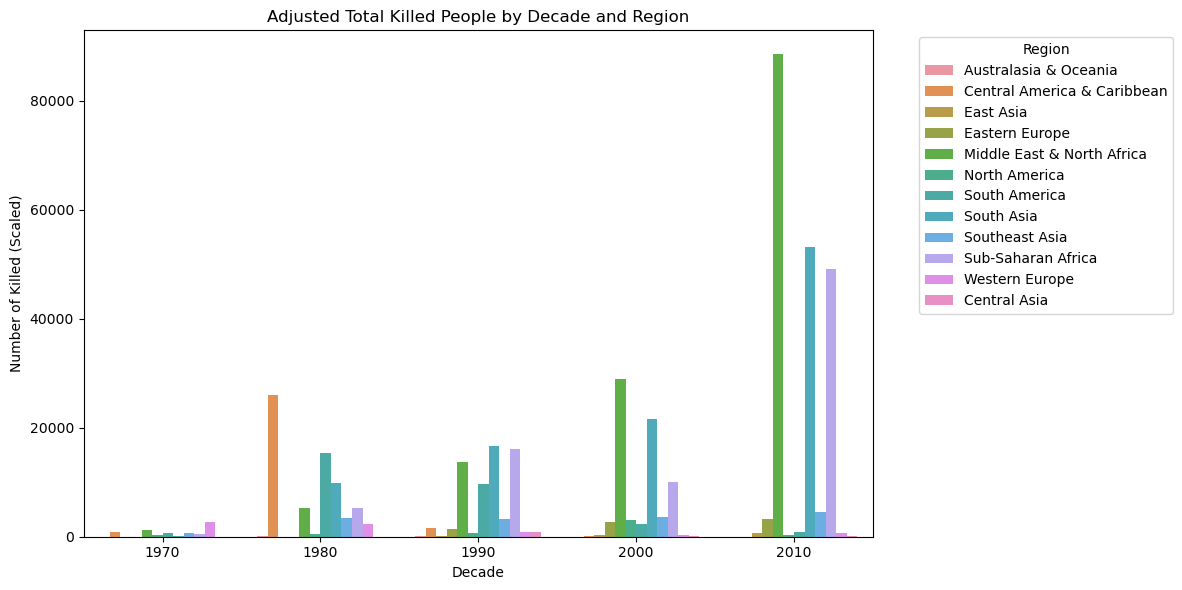

In [21]:
# Calculate total number of killed people per decade for each region
decade_region_totals = merged_df.groupby(['Decade', 'Region'])['Number of Killed People'].sum().reset_index()
decade_region_totals = decade_region_totals.rename(columns={'Number of Killed People': 'Total Killed'})

# Apply log transformation to the total killed values
decade_region_totals['Adjusted Total Killed'] = decade_region_totals['Total Killed'].apply(lambda x: np.log10(x + 1))  # Adding 1 to avoid log(0)

# Plot the grouped statistics with log-transformed values
plt.figure(figsize=(12, 6))
sns.barplot(data=decade_region_totals, x='Decade', y='Total Killed', hue='Region', ci=None)
plt.title('Adjusted Total Killed People by Decade and Region')
plt.ylabel('Number of Killed (Scaled)')
plt.xlabel('Decade')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


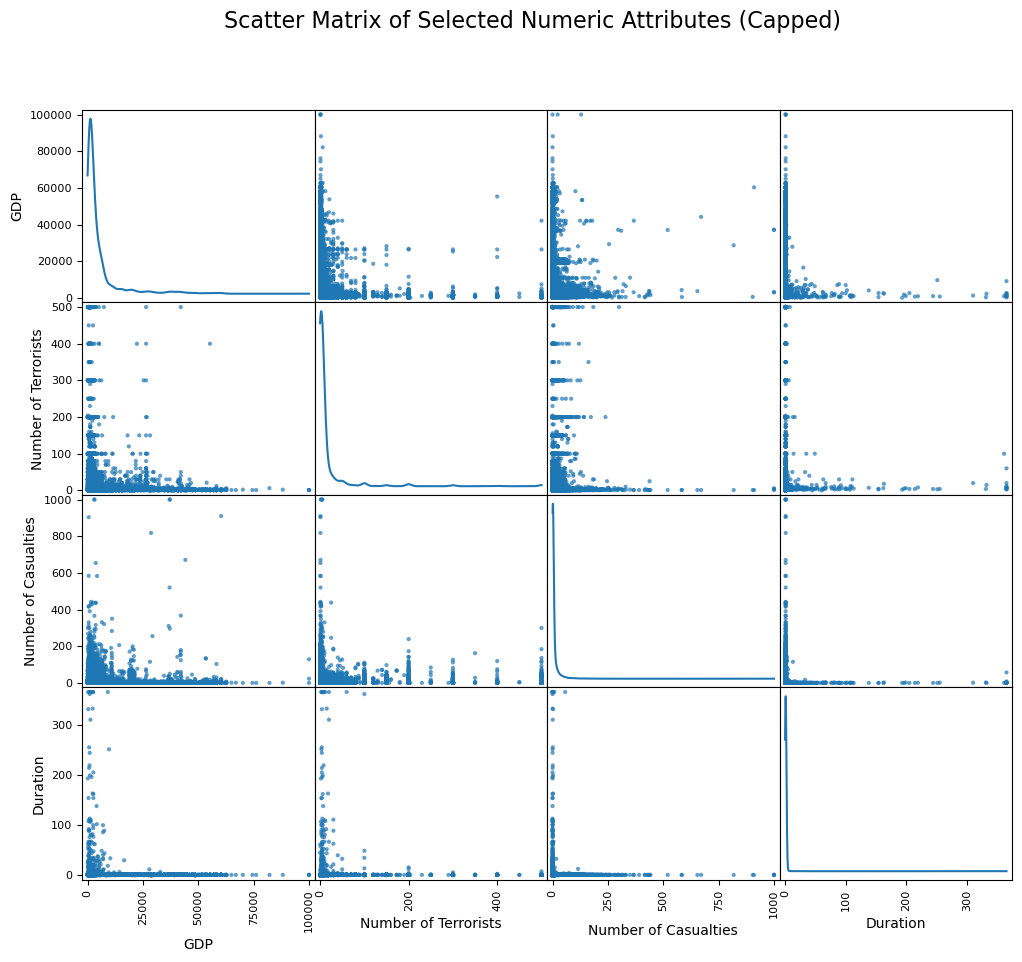

In [24]:
from pandas.plotting import scatter_matrix

numeric_cols = ['GDP', 'Number of Terrorists', 'Number of Casualties', 'Duration']

cleaned_df = (
    merged_df[numeric_cols]
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)

caps = {
    'GDP': 100_000,
    'Number of Terrorists': 500,
    'Number of Casualties': 1000,
    'Duration': 365
}

for col, cap in caps.items():
    cleaned_df[col] = cleaned_df[col].clip(upper=cap)

# Generate and visualize the scatter matrix
scatter_matrix(
    cleaned_df, figsize=(12, 10),
    diagonal='kde', alpha=0.7
)

plt.suptitle('Scatter Matrix of Selected Numeric Attributes (Capped)', fontsize=16)
plt.show()


In [28]:
from scipy.stats import chi2_contingency
import pandas as pd

# Create a contingency table
contingency_table = pd.crosstab(filtered_df['Region'], filtered_df['Attack Type'])

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Organize the results into a DataFrame for better readability
results_df = pd.DataFrame({
    'Metric': ['Chi-Square Statistic', 'P-value', 'Degrees of Freedom'],
    'Value': [chi2, p, dof]
})

# Display the contingency table and expected frequencies
contingency_table_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)

# Print structured results
print("\nChi-Square Test Results:")
print(results_df)

print("\nContingency Table (Observed):")
print(contingency_table)

print("\nExpected Frequencies:")
print(contingency_table_df)

# Interpret the results
if p < 0.05:
    print("\nConclusion: The variables are significantly associated (reject null hypothesis).")
else:
    print("\nConclusion: The variables are not significantly associated (fail to reject null hypothesis).")



Chi-Square Test Results:
                 Metric         Value
0  Chi-Square Statistic  22057.794081
1               P-value      0.000000
2    Degrees of Freedom     88.000000

Contingency Table (Observed):
Attack Type                  Armed Assault  Assassination  Bombing/Explosion  \
Region                                                                         
Australasia & Oceania                   51             36                 75   
Central America & Caribbean           4361           1254               3239   
Central Asia                           116            115                235   
East Asia                              117             55                330   
Eastern Europe                        1274            400               2766   
Middle East & North Africa            9273           4206              30908   
North America                          448            255               1534   
South America                         3875           2745              

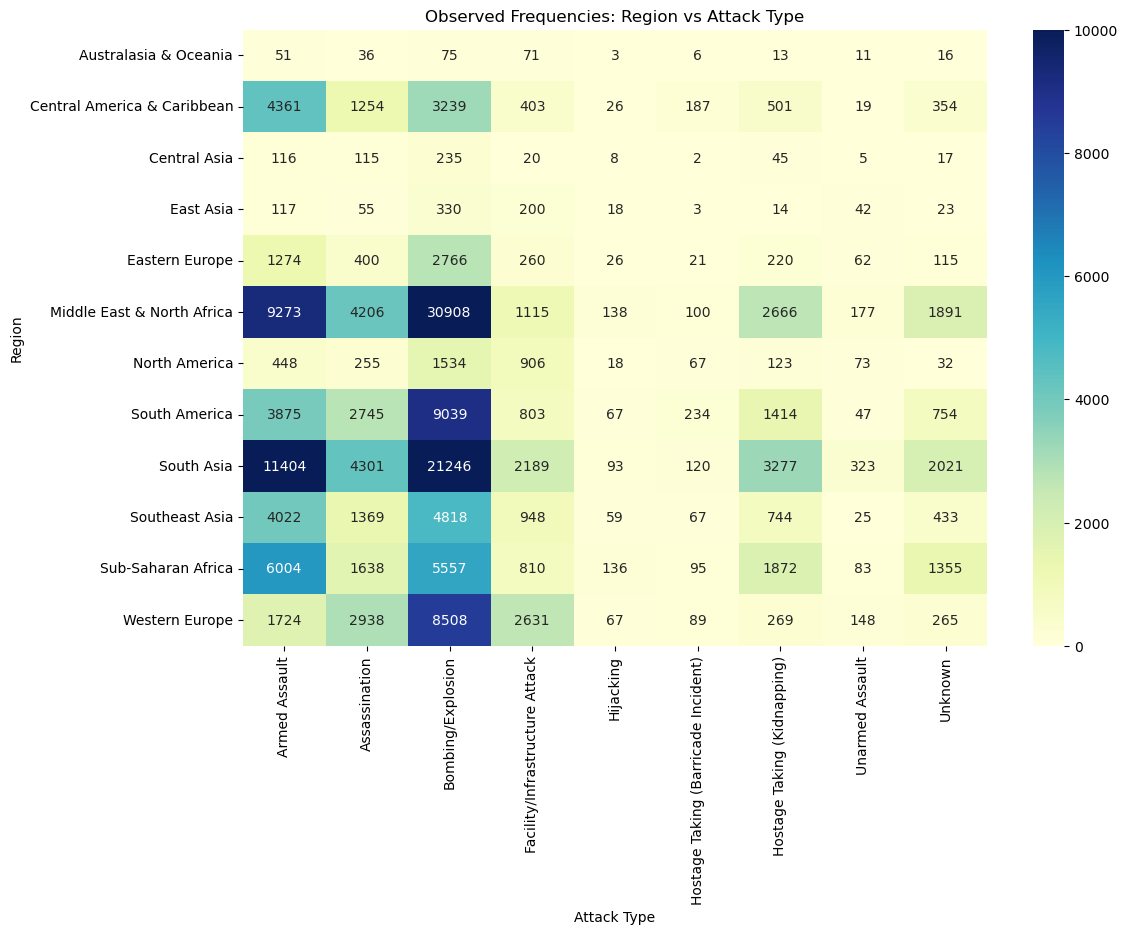

In [34]:
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar=True, vmin=0, vmax=10000)
plt.title("Observed Frequencies: Region vs Attack Type")
plt.xlabel("Attack Type")
plt.ylabel("Region")
plt.show()
